# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

## Local Configuration

While the end goal is for this project to run successfully in the Udacity workspaces, some aspects of the project are easier to iterate on locally.

There are many possible configurations of Python, Jupyter, PyTorch, NVidia with great documentation on the related websites and across the internet, not to mention the various AI Bots including the Udacity course helper bot.

This notebook section captures how we configured a local system for working on this project.

**Basesline System:** 
* OS: WSL-Ubunu 22.04 under Windows 11
* Conda 22.9.0
* Python 3.12.3
* NVidia SMI 555.52.01 / CUDA Version 12.5

All of these steps are performed from the WSL Ubuntu commandline.

1. Create your conda environment
    * We assume you've already installed conda, not covered in these steps.
    * Install Reference: https://docs.anaconda.com/free/anaconda/install/linux/
    
    ```bash
    # if "python" option excluded, will grab latest python, which is currently also 3.12
    conda create -n udacity-aipnd python=3.12

    # be sure to activate!
    conda activate udacity-aipnd
    ```


2. Get the basic python packages
    ```bash
    pip install notebook numpy pandas matplotlib pillow scikit-learn argparse
    # optional: if you do not plan to use a GPU, you can just install torch and torchvision like this and stop here.
    # otherwise, skip this and proceed to step (2)
    pip install torch torchvision
    ```


3. GPU Drivers and CUDA Library

    Review the status of your NVidia configuration with the `nvidia-smi` command.
    * If the `nvidia-smi` command is not availabel, the next steps will document installing it.
    * Our goal is to be compatible with PyTorch, which documents configurations here: https://pytorch.org
    * The `12.5` version we installed is later than the listed compatible versions, but we'll stick with it until we have a reason not to.
    
    *Tips:* You might find references online to `nvcc --version` as a way to dicover your CUDA Version.
        * Read more about why this is misleading: https://stackoverflow.com/questions/53422407/different-cuda-versions-shown-by-nvcc-and-nvidia-smi
        * Summary: trust the output of `nvidia-smi` as the ground truth for what your system is configured to support.

    NVidia on WSL-Ubuntu is very common and well documented.
    * https://developer.nvidia.com/cuda-downloads?target_os=Linux&target_arch=x86_64&Distribution=WSL-Ubuntu&target_version=2.0&target_type=deb_network
    * That longish link filters the options to exactly what we did on our WSL Ubuntu.

    ```bash
    wget https://developer.download.nvidia.com/compute/cuda/repos/wsl-ubuntu/x86_64/cuda-keyring_1.1-1_all.deb
    sudo dpkg -i cuda-keyring_1.1-1_all.deb
    sudo apt-get update
    sudo apt-get -y install cuda-toolkit-12-5
    ```

    After install expect the `nvidia-smi` command to be available and to print a table of configuration information listing `CUDA 12.5`
    * I restarted my WSL Ubuntu after the install, I'm not sure if it was a necessary step.


4. Install PyTorch
    ```bash
    pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
    ```


5. Verify PyTorch Configuration
    Expect to see `True` in the output of this at the commandline.
    ```bash
    python -c 'import torch; print(f"GPU Available: {torch.cuda.is_available()}")'
    ```

6. System Ready!

In [340]:
# Imports here
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import time
import json

Report whether our system will use "gpu" or "cpu" for the learning process.

In [341]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Processing Device: {device_name}")

device = torch.device(device_name)

Processing Device: cuda


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [342]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [343]:
# pixel color normalize stats per ImageNet dataset specification, same values for train and test.
pixel_mean = [0.485, 0.456, 0.406]
pixel_std = [0.229, 0.224, 0.225]
img_crop_size = 224
img_side_px = 255
num_classes = 102

# apply additional transforms to training data to help the learning process generalize the patterns it recognizes
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(img_crop_size),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(pixel_mean, pixel_std)])

# apply only the basic resize/center/normalize to the test and validation data sets.
validation_transforms = transforms.Compose([transforms.Resize(img_side_px),
                                      transforms.CenterCrop(img_crop_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(pixel_mean, pixel_std)])

# use the same transforms for testing as we used for validation
test_transforms = transforms.Compose([transforms.Resize(img_side_px),
                                      transforms.CenterCrop(img_crop_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(pixel_mean, pixel_std)])

# configure the train and test data references to use the respective transforms
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# configure the train and test loaders, using "shuffle" on the training data to avoid bias resulting from processing order.
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [344]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [345]:
# function from the course to show sample image in notebook
# modified to include title and mean/std references to global variable
def imdisplay(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    print(f"image shape: {image.numpy().shape}")
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array(pixel_mean)
        std = np.array(pixel_std)
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    if title:
        ax.set_title(title)

    return ax

def display_labeled_image(image, category, note=""):
    flower_name = cat_to_name[category]
    title = f"({category}) {flower_name} {note}"
    imdisplay(image, title=title)

Show a sample image with numeric category and associated string label from the json file.

image shape: (3, 224, 224)


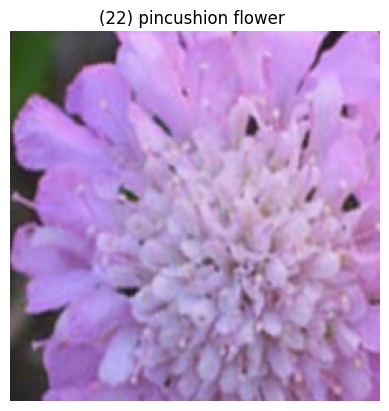

In [346]:
# Get a batch of training data
images, labels = next(iter(trainloader))

# Display the first image from the batch as a quick sample
index = 0  # Change this index to display different images from the batch
flower_category = test_data.classes[labels[index]]
display_labeled_image(images[index], flower_category)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [347]:
def produce_pretrained_model(model_id, freeze_base_model=True):
    ''' Produce a pretrained model for the given model_id

        Arguments
        ---------
        model_id: string identifier for a pretrained model we know how to reconstruct.
        freeze_base_model: when true we set requireds_grad=False for the pretrained model layers.
    '''
    model_instance = None
    if (model_id == 'vgg16'):
        model_instance = models.vgg16(pretrained=True)
    if (model_id == 'vgg19'):
        model_instance = models.vgg19(pretrained=True)
    
    if model_instance:
        if freeze_base_model:
            # Freeze parameters so we don't backprop through them
            for param in model_instance.parameters():
                param.requires_grad = False
        model_instance.model_id = model_id
        return model_instance

    raise Exception(f"Usupported model identifier: {model_id}")

We create the model and freeze the pretrained parameters so we don't mess up what works well in the early layers of the pretrained model.
This seems counter intuitive to the idea that our own additions to the model need to learn something new,
but between the instructor explanation and a discussion with Udacity GPT, it is explained why this actually makes sense.

The short summary of why we freeze parameters is:
1. Faster training because we won't have to update the existing layers in our training.
2. Prevents overfitting because our dataset is smaller and more specific so influencing the base parameters with our data will lose the existing more generalized patterns that already work well.

GPT also notes that finetuning the pretrained layers is sometimes an effective strategy for similarly large datasets, but it sounds like a more advanced tuning approach for a broader problem than the Cat and Dog data we're training our model for with in the context of this course.

In [348]:
# we configure a pre-trained VGG network per suggestion in instructions as a starting point
# of the many VGG variants, we selected vgg16 to start because that worked well for the dog breeds project in a previous course.
model = produce_pretrained_model('vgg16', freeze_base_model=True)
model

/home/morbrian/anaconda3/envs/udacity-aipnd/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/morbrian/anaconda3/envs/udacity-aipnd/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Next we define our classifier, which is a series of layers following after the pretrained network and attempting to improve accuracy on our domain specific flowers dataset.

We define several "producer_" functions to help us identify exactly what we expect to be loaded when we are reconstructing the model and training process from a saved checkpoint file.

In [349]:
def produce_classifier(classifier_id, output_count=102):
    ''' Produce identified instance of Sequential defining the layer architecture for the classifier
        
        Arguments
        ---------
        classifier_id: string identifier of the classifier
        output_count: defines expected size of the output layer
    '''
    classifier_instance = None
    if classifier_id == 'vgg16_first_entry_layer_with_102_class_output':
        classifier_instance = nn.Sequential(OrderedDict([
            ('fc1-from-vgg16', nn.Linear(in_features=25088, out_features=1024, bias=True)),
            ('act1-from-vgg16', nn.ReLU(inplace=True)),
            ('reg1-from-vgg-16', nn.Dropout(p=0.5, inplace=False)),
            ('fc2', nn.Linear(1024, output_count)),
            ('output', nn.LogSoftmax(dim=1))
        ]))
    if classifier_id == 'vgg16_three_entry_layers_two_classifier_layers_with_102_class_output':
        classifier_instance = nn.Sequential(OrderedDict([
            ('fc1-from-vgg16', nn.Linear(in_features=25088, out_features=1024, bias=True)),
            ('act1-from-vgg16', nn.ReLU(inplace=True)),
            ('reg1-from-vgg-16', nn.Dropout(p=0.5, inplace=False)),
            ('fc2-from-vgg16', nn.Linear(in_features=4096, out_features=4096, bias=True)),
            ('act2-from-vgg16', nn.ReLU(inplace=True)),
            ('reg2from-vgg16', nn.Dropout(p=0.5, inplace=False)),
            ('fc3-from-vgg16', nn.Linear(in_features=4096, out_features=1024, bias=True)),
            ('fc4', nn.Linear(4096, 1024)),
            ('act4', nn.ReLU()),
            ('reg4', nn.Dropout(0.5)),
            ('fc5', nn.Linear(1024, output_count)),
            ('output', nn.LogSoftmax(dim=1))
        ]))
    
    if classifier_instance:
        classifier_instance.classifier_id = classifier_id
        classifier_instance.output_count = output_count
        return classifier_instance

    raise Exception(f"No classifier matches id {classifier_id}")


def produce_optimizer(optimizer_id, classifier, learnrate=0.001):
    ''' Produce the optimizer specified by optimizer_id
        Throws exception if an unsupported optimizer is specified.
    '''
    optimizer_instance = None
    if optimizer_id == 'Adam':
        optimizer_instance = optim.Adam(classifier.parameters(), lr=learnrate)
    
    if optimizer_instance:
        optimizer_instance.optimizer_id = optimizer_id
        optimizer_instance.learnrate = learnrate
        return optimizer_instance
    
    raise Exception(f"Unsupported optimizer requested {optimizer_id}")


def produce_criterion(criterion_id):
    ''' Produce the criterion instance for the specified id.
    '''
    criterion_instance = None
    if criterion_id == 'NLLLoss':
        criterion_instance = nn.NLLLoss()
    
    if criterion_instance:
        criterion_instance.criterion_id = criterion_id 
        return criterion_instance 
    
    raise Exception(f"Unsupported criterion request {criterion_id}")


model.classifier = produce_classifier('vgg16_first_entry_layer_with_102_class_output', num_classes)

criterion = produce_criterion('NLLLoss')

optimizer = produce_optimizer('Adam', model.classifier, learnrate=0.001)

model.to(device);

In [350]:
# print out metrics bundle content
def print_metrics_record(metrics_record, include=None, separator='.. '):
    output = []
    if include is None or include.get('training'):
        output.extend([
            f"Epoch {metrics_record['epoch']}/{metrics_record['epochs']}",
            f"Steps: {metrics_record['steps']}",
            f"Train loss: {metrics_record['running_loss']:.3f}",
            f"Train step duration: {metrics_record['step_duration']:.3f}"
        ])
    
    if include is None or include.get('accuracy'):
        output.extend([
            f"Loss: {metrics_record['loss']:.3f}",
            f"Accuracy: {metrics_record['accuracy']*100:.3f}%",
            f"Accuracy Duration: {metrics_record['accuracy_duration']:.3f}"
        ])
    
    print(separator.join(output))

# applies the model to the dataloader series - used by both validation and testing
# qualifier can be any string, but "validation" and "testing" are supported by the metrics printout.
def check_accuracy(model, criterion, dataloader, metrics_record={}):
    loss = 0
    accuracy = 0

    # turn off training during eval to skip training only strategies like Dropout.
    model.eval()
    
    # disable gradient tracking during evaluation to improve performance when we know we won't call backward()
    with torch.no_grad():
        start_time = time.time()
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # run the model on a batch
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)

            # capture some statistics on how the model performed on the data
            loss += batch_loss.item()
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    metrics_record[f"accuracy_duration"] = time.time() - start_time
    # get ready for the next training iteration
    model.train() 

    metrics_record[f"loss"] = loss/len(dataloader)
    metrics_record[f"accuracy"] = accuracy/len(dataloader)


In [351]:

epochs = 1
steps = 0
print_every = 5
# we use the metrics array to store a history of how the accuracy changed during a completed training cycle
# this is useful for post-training analisys
# a single metrics record will be a dictionary with keys like: { epoch, step, running_loss, validation_loss, accuracy }
# we start with a new metrics record added to the aray every "print_every"
metrics = []
def produce_metrics_record():
    return { 
        'running_loss': 0, 
        'epochs': epochs, 
        'step_batch_start': time.time(), 
        'step_batch_size': print_every,
        'device': device,
    }

metrics_record = produce_metrics_record()
for epoch in range(epochs):
    epoch_start = time.time()
    for inputs, labels in trainloader:
        steps +=1
        inputs, labels = inputs.to(device), labels.to(device)

        # capture logarithm of probabilities in the forward step
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        # clear out the gradients before our back propagation to help avoid introducing unintended bias from or previous iterations
        optimizer.zero_grad()
        loss.backward()

        # update parameters with lessons learned in the back prop calculations
        optimizer.step()

        metrics_record['running_loss'] += loss.item()

        if steps % print_every == 0:
            metrics_record['step_duration'] = (time.time() - metrics_record['step_batch_start']) / metrics_record['step_batch_size']
            metrics_record['train_loss'] = metrics_record['running_loss']/metrics_record['step_batch_size']
            metrics_record['epoch'] = epoch+1
            metrics_record['steps'] = steps

            # check accuracy and record metrics
            check_accuracy(model, criterion, validationloader, metrics_record)

            # save record to history
            metrics.append(metrics_record)
            
            # print metrics summary for recent batch of steps
            print_metrics_record(metrics_record)

            # start a new record and maintain the running_loss data
            metrics_record = produce_metrics_record()
            metrics_record['running_loss'] = metrics_record['running_loss']

# clear out gpu memory cache after training complete
torch.cuda.empty_cache()

Epoch 1/1.. Steps: 5.. Train loss: 27.285.. Train step duration: 0.341.. Loss: 4.767.. Accuracy: 17.591%.. Accuracy Duration: 3.669
Epoch 1/1.. Steps: 10.. Train loss: 24.408.. Train step duration: 0.282.. Loss: 3.706.. Accuracy: 27.058%.. Accuracy Duration: 3.650
Epoch 1/1.. Steps: 15.. Train loss: 19.513.. Train step duration: 0.276.. Loss: 3.183.. Accuracy: 31.365%.. Accuracy Duration: 3.743
Epoch 1/1.. Steps: 20.. Train loss: 17.539.. Train step duration: 0.281.. Loss: 2.837.. Accuracy: 38.952%.. Accuracy Duration: 3.703
Epoch 1/1.. Steps: 25.. Train loss: 17.329.. Train step duration: 0.291.. Loss: 2.584.. Accuracy: 41.635%.. Accuracy Duration: 3.726
Epoch 1/1.. Steps: 30.. Train loss: 16.019.. Train step duration: 0.285.. Loss: 2.331.. Accuracy: 47.231%.. Accuracy Duration: 3.636
Epoch 1/1.. Steps: 35.. Train loss: 14.418.. Train step duration: 0.280.. Loss: 2.028.. Accuracy: 52.995%.. Accuracy Duration: 3.664
Epoch 1/1.. Steps: 40.. Train loss: 13.475.. Train step duration: 0.29

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [352]:
# check accuracy and record metrics
# our "check_accuracy" function encapsulates testing steps, and is also the same function we used for validation
metrics_record = {}
check_accuracy(model, criterion, testloader, metrics_record)

# print metrics summary for recent batch of steps
print_metrics_record(metrics_record, include={ 'accuracy': True })

# remember the accuracy rating so we can easily compare this after saving/restoring the model to verify it matches.
recorded_accuracy = metrics_record['accuracy']

# clear out gpu memory cache after testing complete
torch.cuda.empty_cache()

Loss: 1.023.. Accuracy: 71.260%.. Accuracy Duration: 3.779


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [353]:
def save_model(model, filename, class_to_name=None, train_data=None, optimizer=None, criterion=None):
    ''' Create a checkpoint file in a format we can restore later
        Checkpoint structure:
            model_id: identifier of a pretrained basemodel we can reconstruct
            classiifier_id: identifier of a classifier archticture we can reconstruct
            output_count: number of output categories the classifier should reproduce
            state_dict: standard format for torch serialized model.state_dict with model parameters
            integrity_check: text representation of model used to verify the reconstructed model architecture matches the saved model
            data_mapping_metadata: parameters used for data loading and category naming
            training_metadata: supporting properties to reconsruct necessary training objects like the optimizer.
            evaluation_metadata: supporting properties to reconstruct necessary objects for validation and testing, like criterion.
        
        Arguments
        ---------
        model: the trained model
        filename: name of file to save model state to
    '''
    checkpoint = {
        'model_id': model.model_id,
        'classifier_id': model.classifier.classifier_id,
        'output_count': model.classifier.output_count,
        'state_dict': model.state_dict(),
        'integrity_check': str(model),
        'data_mapping_metadata': {
            'class_to_idx': train_data.class_to_idx if train_data else None,
            'class_to_name': json.dumps(class_to_name) if class_to_name else None
        },
        'training_metadata': {
            'optimizer_id': optimizer.optimizer_id if optimizer else None,
            'learnrate': optimizer.learnrate if optimizer else None,
            'optimizer_state': optimizer.state_dict() if optimizer else None,
        },
        'evaluation_metadata': {
            'criterion_id': criterion.criterion_id if criterion else None
        }
    }
    torch.save(checkpoint, filename)

# save checkpoint to file
save_model(model, 'checkpoint.pth', class_to_name=cat_to_name, train_data=train_data, optimizer=optimizer, criterion=criterion)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [354]:
def load_model_bundle(filepath):
    ''' Load model from a checkpoint 
        Checkpoint structure:
            model_id: identifier of a pretrained basemodel we can reconstruct
            classiifier_id: identifier of a classifier archticture we can reconstruct
            output_count: number of output categories the classifier should reproduce
            state_dict: standard format for torch serialized model.state_dict with model parameters
            integrity_check: text representation of model used to verify the reconstructed model architecture matches the saved model
            data_mapping_metadata: parameters used for data loading and category naming
            training_meta_data: supporting properties to reconsruct necessary training objects like the optimizer.
            evaluation_meta_data: supporting properties to reconstruct necessary objects for validation and testing, like criterion.

        Arguments
        ---------
        filepath: filename of checkpoint file to load.

        Throws
        ------
        Exception if restored model does not match integrity_check field of checkpoint file.
        Exception if we don't support reconsructing the model_id specified in checkpoint file.
        Exception if we don't support reconsructing the classifier_id specified in checkpoint file.
    '''
    checkpoint = torch.load(filepath)
    # we load the pretrained model identified by model_id
    model_id = checkpoint['model_id']
    base_model = produce_pretrained_model(model_id)
    # we set classifier to our layer Sequence referenced by classifier
    classifier_id = checkpoint['classifier_id']
    output_count = checkpoint['output_count']
    base_model.classifier = produce_classifier(classifier_id, output_count)
    base_model.load_state_dict(checkpoint['state_dict'])
    # verify the archtitecture we loaded matches what we saved
    integrity_check = checkpoint['integrity_check']
    if integrity_check != str(base_model):
        raise Exception(f"Loaded model architecture differes from what was saved.")
    
    criterion = None
    optimizer = None
    class_to_name = None 
    class_to_idx = None

    data_mapping_metadata = checkpoint.get('data_mapping_metadata', None)
    if data_mapping_metadata:
        class_to_name_data = data_mapping_metadata.get('class_to_name', None)
        class_to_name = json.loads(class_to_name_data) if class_to_name_data else None 
        class_to_idx = data_mapping_metadata.get('class_to_idx', None)
    
    training_metadata = checkpoint.get('training_metadata', None)
    if training_metadata:
        optimizer_id = training_metadata.get('optimizer_id', None)
        learnrate = training_metadata['learnrate'] if optimizer_id else None
        optimizer = produce_optimizer(training_metadata['optimizer_id'], base_model.classifier, learnrate=learnrate) if optimizer_id else None
        if optimizer: 
            optimizer.load_state_dict(training_metadata['optimizer_state'])
    
    evaluation_metadata = checkpoint.get('evaluation_metadata', None)
    if evaluation_metadata:
        criterion_id = evaluation_metadata.get('criterion_id', None)
        criterion = produce_criterion(criterion_id) if criterion_id else None

    return {
        'model': model,
        'criterion': criterion,
        'optimizer': optimizer,
        'class_to_name': class_to_name,
        'class_to_idx': class_to_idx,
    }

bundle = load_model_bundle('checkpoint.pth')

restored_model = bundle['model']
restored_criterion = bundle['criterion']
restored_optimizer = bundle['optimizer']
restored_class_to_name = bundle['class_to_name']
restored_class_to_idx = bundle['class_to_idx']

Now that we have the reloaded model available, lets check that we git the same results we were producing before we saved it.

In [355]:
# move the restored model to the processor we're using
restored_model = restored_model.to(device)
restored_criterion = restored_criterion.to(device)

# check the accuracy and record metrics
metrics_record = {}
check_accuracy(restored_model, restored_criterion, testloader, metrics_record)

# print metrics summary for the accuracy check
print_metrics_record(metrics_record, include={ 'accuracy': True })

print(f"Accuracy on Save: {recorded_accuracy}.. Accuracy on Restore: {metrics_record['accuracy']}")

Loss: 1.023.. Accuracy: 71.260%.. Accuracy Duration: 3.841
Accuracy on Save: 0.7125989840580866.. Accuracy on Restore: 0.7125989840580866


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [356]:
def process_image(image, short_size=256, img_crop_size=img_crop_size):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    shorter_side = image.height if image.height < image.width else image.width
    scaling = shorter_side // short_size
    new_height = image.height * scaling
    new_width = image.width * scaling

    im_resized = image.resize((new_width, new_height))
    edge_dist = img_crop_size // 2
    center_x = new_width // 2
    center_y = new_height // 2
    upper = center_y - edge_dist
    left = center_x - edge_dist 
    lower = center_y + edge_dist
    right = center_x + edge_dist
    im_cropped = im_resized.crop([left, upper, right, lower])

    # comment out dimension logging
    # print(f"cropped image dims: h({im_cropped.height}) w({im_cropped.width})")

    im = np.array(im_cropped) / 255.0
    im = (im - pixel_mean) / pixel_std
    im = im.transpose((2, 0, 1))

    # comment out dimnsion logging
    # print(f"numpy image array shape: {im.shape}")

    return im




To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [357]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    

    if title:
        ax.set_title(title)
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(pixel_mean)
    std = np.array(pixel_std)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

Display the original image followed by the processed version of the image to verify the images are the same, aside from the cropped sections.

Original image, unmodified:

<img src='assets/sample-flower.jpg' width=500px>

<Axes: >

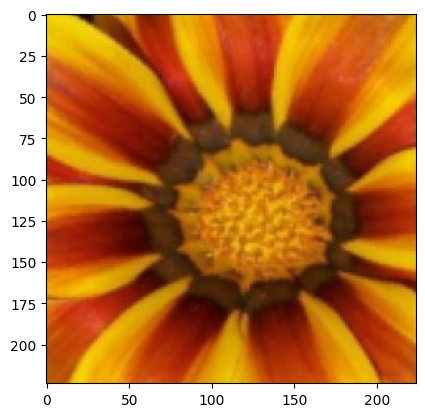

In [358]:
sample_image_path = 'assets/sample-flower.jpg'
processed_image = None
with Image.open(sample_image_path) as pil_image:
    processed_image = process_image(pil_image)

torch_image = torch.from_numpy(processed_image).float()
imshow(torch_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [359]:
def predict(image_path, model, category_names=cat_to_name, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
        Return a ziped list of the topk picks: (category_index, category_name, probability)
    '''
    processed_image = None
    with Image.open(image_path) as pil_image:
        processed_image = process_image(pil_image)

    torch_image = torch.from_numpy(processed_image).float().unsqueeze(0)
    torch_image = torch_image.to(device)
    model.eval()
    model.to(device)
    logps = model.forward(torch_image)
    ps = torch.exp(logps)
    model.train()

    top_values, top_indices = torch.topk(ps, k=topk)
    top_names = [category_names[str(idx)] for idx in top_indices[0].tolist()]

    return zip(top_indices[0].tolist(), top_names, top_values[0].tolist())

In [360]:
top_predictions = list(predict(sample_image_path, restored_model))

# print top_predictions
print(f"Top Predictions (index, name, probability)")
for category, name, probability in top_predictions:
    print(f"{category} {name} {probability*100:.3}%")

Top Predictions (index, name, probability)
71 gazania 98.4%
47 marigold 0.568%
57 gaura 0.46%
82 clematis 0.217%
43 sword lily 0.0931%


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

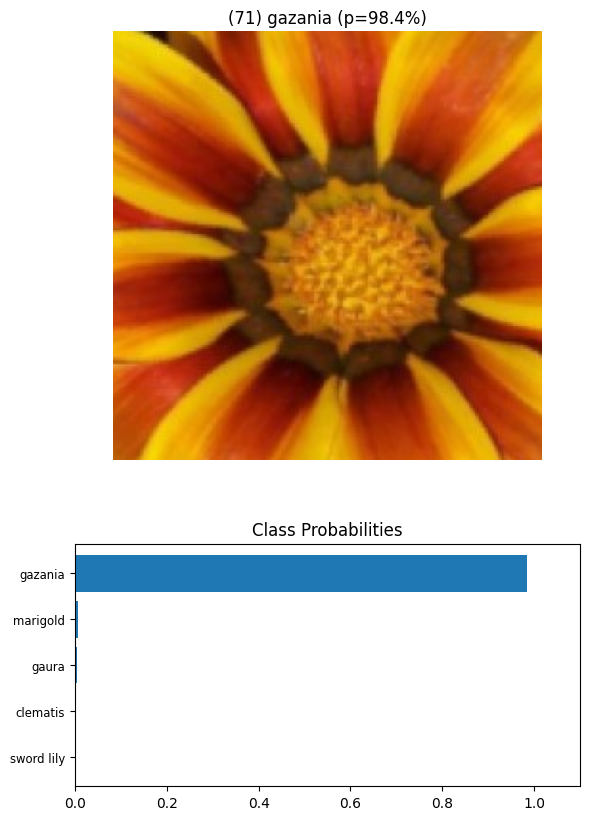

In [361]:
def display_top_predictions(image, top_predictions):
    ''' Show graph of top predictions
    '''
    top_cat, top_name, top_p = top_predictions[0]
    # reverse the list in descending order so the highest probability graphs on top
    categories, names, probabilities = zip(*top_predictions[::-1])
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), nrows=2)
    imshow(image, ax1, title=f"({top_cat}) {top_name} (p={top_p*100:.3}%)")
    ax1.axis('off')
    ax2.barh(np.arange(len(probabilities)), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(probabilities)))
    ax2.set_yticklabels(names, size='small')
    ax2.set_title("Class Probabilities")
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


display_top_predictions(torch_image, top_predictions)
